In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import os
import pickle
from sklearn import metrics

import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.insert(0, '../common')
from utils import tunable_parameters
from utils import device

In [3]:
from train import input_dim
from train import hidden_dim
from train import batch_size
from train import n_lstm_layers

In [4]:
def predict_IsGoodTrack(model, input, batch_size):
    """
    predict the model of IsGoodTrack
    """
    with torch.no_grad():
        input_tensor = torch.from_numpy(input)
        input_tensor = input_tensor.expand(batch_size, *input_tensor.size())
        input_tensor = input_tensor.to(device)
        output = model(input_tensor.view(batch_size, -1))
        return output[0]

In [17]:
def get_roc(model, real_tracks, fake_tracks):
    y = []
    scores = []
    for real_track in real_tracks[:1000]:
        output = predict_IsGoodTrack(model, real_track, batch_size)
        scores.append(output)
        y.append(1)

    for fake_track in fake_tracks[:1000]:
        output = predict_IsGoodTrack(model, fake_track, batch_size)
        if output is None:
            continue
        scores.append(output)
        y.append(0)


    fpr, tpr, thresholds = metrics.roc_curve(y, scores)
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim(0., 1.0)
    plt.ylim(0., 1.0)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.savefig("roc.png")
    print("scores:", metrics.roc_auc_score(y, scores))

In [32]:
from is_good_track import IsGoodTrack
from process_data import get_real_tracks
from process_data import get_fake_tracks
from process_data import random_inputs

def check(options):
    # create RNN model
    model = IsGoodTrack(input_dim, hidden_dim,
                        batch_size=batch_size,
                        n_lstm_layers=n_lstm_layers,
                        device=device)
    model.to(device)
    model.hidden = model.init_hidden()
    print("total parameters:", tunable_parameters(model))
    print(model.hidden[0].type())

    model_name = os.path.join(options.output, 'model_isgoodtrack')
    model.load_state_dict(torch.load(model_name))


    # test with another event!
    real_tracks_out_name = os.path.join(options.output, 'reak_tracks_pad_{}.pkl'.format(options.posfix))
    fake_tracks_out_name = os.path.join(options.output, 'fake_tracks_pad_{}.pkl'.format(options.posfix))
    
    if os.path.exists(real_tracks_out_name):
        real_tracks = pickle.load(open(real_tracks_out_name, 'rb'))
        fake_tracks = pickle.load(open(fake_tracks_out_name, 'rb'))
    else:
        real_tracks = get_real_tracks(options.event)
        fake_tracks = get_fake_tracks(options.event, real_tracks.shape[0])
        # save the two dataset
        with open(fake_tracks_out_name, 'wb') as fp:
            pickle.dump(fake_tracks, fp)

        with open(real_tracks_out_name, 'wb') as fp:
            pickle.dump(real_tracks, fp)
    
    real_tracks = pickle.load(open(real_tracks_out_name, 'rb'))
    fake_tracks = pickle.load(open(fake_tracks_out_name, 'rb'))

    get_roc(model, real_tracks, fake_tracks)

In [33]:
from collections import namedtuple
Options = namedtuple('Options', ['output', 'event', 'posfix'])

total parameters: 89701
torch.FloatTensor
scores: 0.804034


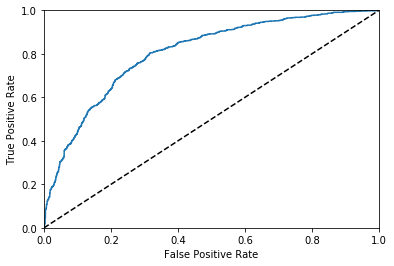

In [34]:
options = Options(output='output', event='../ipynb/input/train_1/event000001001', posfix='e2')
check(options)

total parameters: 89701
torch.FloatTensor
scores: 0.8466009999999999


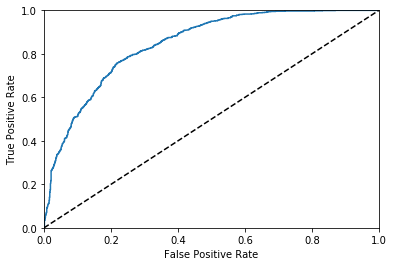

In [35]:
options = Options(output='output', event='../ipynb/input/train_1/event000001000', posfix='e0')
check(options)

total parameters: 89701
torch.FloatTensor
scores: 0.7951374999999999


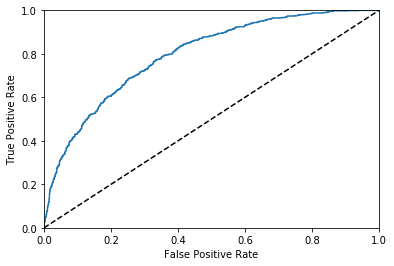

In [36]:
options = Options(output='output', event='../ipynb/input/train_1/event000001002', posfix='e1')
check(options)

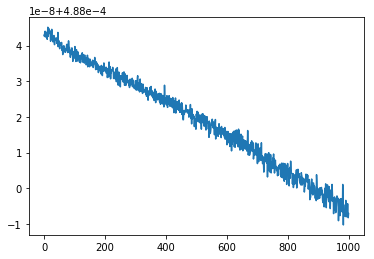

In [21]:
loss = pickle.load(open(os.path.join(options.output, 'loss_2.pkl'), 'rb'))
plt.plot(loss)